In [3]:
import os 
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt

from collections import Counter

In [4]:
%matplotlib inline

In [5]:
# Some of the columns we will look at can be quite wide, but it's good to get an idea of what they contain
print(pd.get_option('max_colwidth'))
pd.set_option('max_colwidth',500)

50


## File/dir locations


In [6]:
DATA_DIR = os.getenv("DATA_DIR")
filename = "preprocessed_taxon_pageseq_20190114_20190116.csv.gz"
# df_file = os.path.join(DATA_DIR, "processed_journey", filename)
# df_reduced_file = os.path.join(DATA_DIR, "processed_journey", "reduced_"+filename)
# df_rel_file = os.path.join(DATA_DIR, "processed_journey", "rel_"+filename)
df_doo_file = os.path.join(
    DATA_DIR, "processed_journey",
    "doo_prelim_meta_standard_with_pageseq_from_29-10_to_04-11-2018.csv.gz")

Load up a data file that isn't too large - we just want to check that the putative metrics for analysis can be derived from the data. This data was produced by an early version of the pipeline and is missing some descriptive variables, such as taxons etc. However, it contains the sequences of pages and behaviours (or events) of users on those pages, including interaction with the sidebar and the related links contained therein.

In [88]:
df = pd.read_csv(df_doo_file, compression="gzip")

In [89]:
df.head(2)

,Sequence,PageSequence,Occurrences,Page_Seq_Occurrences,DeviceCategories,Dates,Page_Event_List,Page_List,PageSequence_internal,Event_List,num_event_cats,Event_cats_agg,Event_cat_act_agg,Page_List_NL,Page_Seq_NL,Occurrences_NL
0,/guidance/rates-and-thresholds-for-employers-2016-to-2017<<PAGE<:<NULL<:<NULL,/guidance/rates-and-thresholds-for-employers-2016-to-2017,87,306.0,"[('desktop', 64), ('mobile', 11), ('tablet', 12)]","[('20181031', 33), ('20181029', 27), ('20181102', 17), ('20181104', 10)]","[('/guidance/rates-and-thresholds-for-employers-2016-to-2017', 'PAGE<:<NULL<:<NULL')]",['/guidance/rates-and-thresholds-for-employers-2016-to-2017'],/guidance/rates-and-thresholds-for-employers-2016-to-2017,"[('PAGE_NULL', 'PAGE_NULL')]",1,"[('PAGE_NULL', 1)]","[(('PAGE_NULL', 'PAGE_NULL'), 1)]",['/guidance/rates-and-thresholds-for-employers-2016-to-2017'],/guidance/rates-and-thresholds-for-employers-2016-to-2017,6198.0
1,/sure-start-maternity-grant/how-to-claim<<PAGE<:<NULL<:<NULL>>/government/publications/sure-start-maternity-grant-claim-form<<PAGE<:<NULL<:<NULL>>/government/publications/sure-start-maternity-grant-claim-form<<EVENT<:<External Link Clicked<:<https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/749722/sure-start-maternity-grant-sf100.pdf>>/government/publications/sure-start-maternity-grant-claim-form<<EVENT<:<Download Link Clicked<:<https://assets.pu...,/sure-start-maternity-grant/how-to-claim>>/government/publications/sure-start-maternity-grant-claim-form,104,385.0,"[('mobile', 50), ('desktop', 50), ('tablet', 4)]","[('20181031', 34), ('20181029', 31), ('20181102', 24), ('20181104', 15)]","[('/sure-start-maternity-grant/how-to-claim', 'PAGE<:<NULL<:<NULL'), ('/government/publications/sure-start-maternity-grant-claim-form', 'PAGE<:<NULL<:<NULL'), ('/government/publications/sure-start-maternity-grant-claim-form', 'EVENT<:<External Link Clicked<:<https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/749722/sure-start-maternity-grant-sf100.pdf'), ('/government/publications/sure-start-maternity-grant-claim-form', 'EVENT<:<Download Link Clic...","['/sure-start-maternity-grant/how-to-claim', '/government/publications/sure-start-maternity-grant-claim-form']",/sure-start-maternity-grant/how-to-claim>>/government/publications/sure-start-maternity-grant-claim-form,"[('PAGE_NULL', 'PAGE_NULL'), ('PAGE_NULL', 'PAGE_NULL'), ('External Link Clicked', 'https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/749722/sure-start-maternity-grant-sf100.pdf'), ('Download Link Clicked', 'https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/749722/sure-start-maternity-grant-sf100.pdf')]",3,"[('PAGE_NULL', 2), ('External Link Clicked', 1), ('Download Link Clicked', 1)]","[(('PAGE_NULL', 'PAGE_NULL'), 2), (('External Link Clicked', 'https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/749722/sure-start-maternity-grant-sf100.pdf'), 1), (('Download Link Clicked', 'https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/749722/sure-start-maternity-grant-sf100.pdf'), 1)]","['/sure-start-maternity-grant/how-to-claim', '/government/publications/sure-start-maternity-grant-claim-form']",/sure-start-maternity-grant/how-to-claim>>/government/publications/sure-start-maternity-grant-claim-form,7010.0


In [90]:
df.shape

(2035522, 16)

## Remove tablet occurrences

In [91]:
def device_count(x, device):
    return sum([value for item, value in x if item == device])
df["TabletCount"] = df['DeviceCategories'].apply(
    ast.literal_eval).map(lambda x: device_count(x, "tablet"))
df["Occurrences"] = df["Occurrences"] - df["TabletCount"]

In [92]:
df[df["Occurrences"] == 0].shape

(142109, 17)

In [93]:
df = df[df["Occurrences"] != 0]

In [94]:
df.shape

(1893413, 17)

In [95]:
df.head(2)

,Sequence,PageSequence,Occurrences,Page_Seq_Occurrences,DeviceCategories,Dates,Page_Event_List,Page_List,PageSequence_internal,Event_List,num_event_cats,Event_cats_agg,Event_cat_act_agg,Page_List_NL,Page_Seq_NL,Occurrences_NL,TabletCount
0,/guidance/rates-and-thresholds-for-employers-2016-to-2017<<PAGE<:<NULL<:<NULL,/guidance/rates-and-thresholds-for-employers-2016-to-2017,75,306.0,"[('desktop', 64), ('mobile', 11), ('tablet', 12)]","[('20181031', 33), ('20181029', 27), ('20181102', 17), ('20181104', 10)]","[('/guidance/rates-and-thresholds-for-employers-2016-to-2017', 'PAGE<:<NULL<:<NULL')]",['/guidance/rates-and-thresholds-for-employers-2016-to-2017'],/guidance/rates-and-thresholds-for-employers-2016-to-2017,"[('PAGE_NULL', 'PAGE_NULL')]",1,"[('PAGE_NULL', 1)]","[(('PAGE_NULL', 'PAGE_NULL'), 1)]",['/guidance/rates-and-thresholds-for-employers-2016-to-2017'],/guidance/rates-and-thresholds-for-employers-2016-to-2017,6198.0,12
1,/sure-start-maternity-grant/how-to-claim<<PAGE<:<NULL<:<NULL>>/government/publications/sure-start-maternity-grant-claim-form<<PAGE<:<NULL<:<NULL>>/government/publications/sure-start-maternity-grant-claim-form<<EVENT<:<External Link Clicked<:<https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/749722/sure-start-maternity-grant-sf100.pdf>>/government/publications/sure-start-maternity-grant-claim-form<<EVENT<:<Download Link Clicked<:<https://assets.pu...,/sure-start-maternity-grant/how-to-claim>>/government/publications/sure-start-maternity-grant-claim-form,100,385.0,"[('mobile', 50), ('desktop', 50), ('tablet', 4)]","[('20181031', 34), ('20181029', 31), ('20181102', 24), ('20181104', 15)]","[('/sure-start-maternity-grant/how-to-claim', 'PAGE<:<NULL<:<NULL'), ('/government/publications/sure-start-maternity-grant-claim-form', 'PAGE<:<NULL<:<NULL'), ('/government/publications/sure-start-maternity-grant-claim-form', 'EVENT<:<External Link Clicked<:<https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/749722/sure-start-maternity-grant-sf100.pdf'), ('/government/publications/sure-start-maternity-grant-claim-form', 'EVENT<:<Download Link Clic...","['/sure-start-maternity-grant/how-to-claim', '/government/publications/sure-start-maternity-grant-claim-form']",/sure-start-maternity-grant/how-to-claim>>/government/publications/sure-start-maternity-grant-claim-form,"[('PAGE_NULL', 'PAGE_NULL'), ('PAGE_NULL', 'PAGE_NULL'), ('External Link Clicked', 'https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/749722/sure-start-maternity-grant-sf100.pdf'), ('Download Link Clicked', 'https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/749722/sure-start-maternity-grant-sf100.pdf')]",3,"[('PAGE_NULL', 2), ('External Link Clicked', 1), ('Download Link Clicked', 1)]","[(('PAGE_NULL', 'PAGE_NULL'), 2), (('External Link Clicked', 'https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/749722/sure-start-maternity-grant-sf100.pdf'), 1), (('Download Link Clicked', 'https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/749722/sure-start-maternity-grant-sf100.pdf'), 1)]","['/sure-start-maternity-grant/how-to-claim', '/government/publications/sure-start-maternity-grant-claim-form']",/sure-start-maternity-grant/how-to-claim>>/government/publications/sure-start-maternity-grant-claim-form,7010.0,4


## Planning

Inspecting our putative metrics for detecting a change in user navigation experience gives us three ratios. Thus we need to check that we can get the numerator and denominator from the data for each of these metrics.


In [11]:
events = []
for items in df['Event_cat_act_agg'].apply(ast.literal_eval):
    for event in items:
        events.append(event[0])

In [45]:
events[:4]

[('PAGE_NULL', 'PAGE_NULL'),
 ('PAGE_NULL', 'PAGE_NULL'),
 ('External Link Clicked',
  'https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/749722/sure-start-maternity-grant-sf100.pdf'),
 ('Download Link Clicked',
  'https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/749722/sure-start-maternity-grant-sf100.pdf')]

In [ ]:
Counter(events)

Potential nav events eventCategory:
- breadcrumbClicked
- homeLinkClicked
- searchResults
- relatedLinkClicked (eventAction e.g. 1.1 Explore the topic)

Related link events eventCategory:
- relatedLinkClicked (eventAction e.g. 1.3 Related content)

## journey_click_rate
There is no difference in the proportion of journeys using at least one related link (journey_click_rate) between page variant A and page variant B.



\begin{equation*}
\frac{\text{total number of journeys including at least one click on a related link}}{\text{total number of journeys}}
\end{equation*}

### total number of journeys including at least one click on a related link
The numerator.

We need to check within the Sequence column, whether the corresponding user journey has an Event where a related link was clicked. There are more than one level to this Event, we are specifically interestd in "Related content" (as this is the sidebar of the page, the related links we are interested in).

In [10]:
#Compute whether a journey includes at least one related link click
def is_related(x):
    return all(cond in x for cond in ["relatedLinkClicked","Related content"])

Please note, `is_related` does not make sure that `relatedLinkClicked` and `Related content` exist in the same event in `Sequence`

In [11]:
is_related(
    '/garden-bonfires-rules<<PAGE<:<relatedLinkClicked<:<NULL>>/garden-bonfires-rules<<EVENT<:<NULL<:<1.4 Related content'
    )

True

In [12]:
# map across the Sequence variable, which includes pages and Events
# we want to pass all the list elements to a function one-by-one and then collect the output.
df["Has_Related"] = df["Sequence"].map(is_related)

In [13]:
# this gives a logical column
df["Has_Related"].head()

0    False
1    False
2    False
3    False
4    False
Name: Has_Related, dtype: bool

In [14]:
# We can filter for True and sum
df[df["Has_Related"]].Occurrences.sum()

150573

In [15]:
df['Sequence'][2608]

'/garden-bonfires-rules<<PAGE<:<NULL<:<NULL>>/garden-bonfires-rules<<EVENT<:<relatedLinkClicked<:<1.4 Related content'

In [16]:
all(cond in
    '/garden-bonfires-rules<<PAGE<:<NULL<:<NULL>>/garden-bonfires-rules<<EVENT<:<relatedLinkClicked<:<1.4 Related content'
    for cond in ["relatedLinkClicked","Related content"])

True

In [17]:
# sense check by inspecting filtered df
df[df["Has_Related"]].head(3)

,Sequence,PageSequence,Occurrences,Page_Seq_Occurrences,DeviceCategories,Dates,Page_Event_List,Page_List,PageSequence_internal,Event_List,num_event_cats,Event_cats_agg,Event_cat_act_agg,Page_List_NL,Page_Seq_NL,Occurrences_NL,Has_Related
2608,/garden-bonfires-rules<<PAGE<:<NULL<:<NULL>>/garden-bonfires-rules<<EVENT<:<relatedLinkClicked<:<1.4 Related content,/garden-bonfires-rules,1,7483.0,"[('mobile', 1)]","[('20181031', 1)]","[('/garden-bonfires-rules', 'PAGE<:<NULL<:<NULL'), ('/garden-bonfires-rules', 'EVENT<:<relatedLinkClicked<:<1.4 Related content')]",['/garden-bonfires-rules'],/garden-bonfires-rules,"[('PAGE_NULL', 'PAGE_NULL'), ('relatedLinkClicked', '1.4 Related content')]",2,"[('PAGE_NULL', 1), ('relatedLinkClicked', 1)]","[(('PAGE_NULL', 'PAGE_NULL'), 1), (('relatedLinkClicked', '1.4 Related content'), 1)]",['/garden-bonfires-rules'],/garden-bonfires-rules,114000.0,True
3401,/check-state-pension<<PAGE<:<NULL<:<NULL>>/check-state-pension<<EVENT<:<relatedLinkClicked<:<1.1 Related content,/check-state-pension,1,17093.0,"[('mobile', 1)]","[('20181031', 1)]","[('/check-state-pension', 'PAGE<:<NULL<:<NULL'), ('/check-state-pension', 'EVENT<:<relatedLinkClicked<:<1.1 Related content')]",['/check-state-pension'],/check-state-pension,"[('PAGE_NULL', 'PAGE_NULL'), ('relatedLinkClicked', '1.1 Related content')]",2,"[('PAGE_NULL', 1), ('relatedLinkClicked', 1)]","[(('PAGE_NULL', 'PAGE_NULL'), 1), (('relatedLinkClicked', '1.1 Related content'), 1)]",['/check-state-pension'],/check-state-pension,413249.0,True
4353,/child-benefit-rates<<EVENT<:<relatedLinkClicked<:<1.6 Related content>>/child-tax-credit<<PAGE<:<NULL<:<NULL,/child-tax-credit,2,4239.0,"[('mobile', 1), ('desktop', 1)]","[('20181031', 1), ('20181029', 1)]","[('/child-benefit-rates', 'EVENT<:<relatedLinkClicked<:<1.6 Related content'), ('/child-tax-credit', 'PAGE<:<NULL<:<NULL')]",['/child-tax-credit'],/child-tax-credit,"[('relatedLinkClicked', '1.6 Related content'), ('PAGE_NULL', 'PAGE_NULL')]",2,"[('relatedLinkClicked', 1), ('PAGE_NULL', 1)]","[(('relatedLinkClicked', '1.6 Related content'), 1), (('PAGE_NULL', 'PAGE_NULL'), 1)]",['/child-tax-credit'],/child-tax-credit,51353.0,True


### total number of journeys
The denominator.

In [13]:
df.Occurrences.sum()

11544061

### final metric

Given this sample, we see:

In [14]:
df[df["Has_Related"]].Occurrences.sum() / df.Occurrences.sum()

0.01304333024574281

The above metric considers at least one related link clicked, but on some journeys more than one related link might get clicked. We can use the following columns to help us.

In [15]:
df['Event_cats_agg'].head(3)

0                                                                [('PAGE_NULL', 1)]
1    [('PAGE_NULL', 2), ('External Link Clicked', 1), ('Download Link Clicked', 1)]
2                                                                [('PAGE_NULL', 1)]
Name: Event_cats_agg, dtype: object

In [16]:
df['Event_cat_act_agg'].head(3)

0                                                                                                                                                                                                                                                                                                                                                                  [(('PAGE_NULL', 'PAGE_NULL'), 1)]
1    [(('PAGE_NULL', 'PAGE_NULL'), 2), (('External Link Clicked', 'https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/749722/sure-start-maternity-grant-sf100.pdf'), 1), (('Download Link Clicked', 'https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/749722/sure-start-maternity-grant-sf100.pdf'), 1)]
2                                                                                                                                                                                                                             

## ratio of clicks on navigation elements vs. clicks on related links

There is no statistically significant difference in the ratio of clicks on navigation elements vs. clicks on related links between page variant A and page variant B

\begin{equation*}
\frac{\text{total number of navigation element click events from content pages}}{\text{total number of related link click events}}
\end{equation*}

### total number of related link click events

we need to check `Related content` is in the event, because the `relatedLinkClicked` is also used for "explore the topic" links at the bottom of the page, with the event action containing `Explore the topic`, e.g. `(('relatedLinkClicked', '2.1 Explore the topic'), 1)`

In [18]:
# example of Event_cat_act_agg
df['Event_cat_act_agg'][2035492]

"[(('PAGE_NULL', 'PAGE_NULL'), 4), (('user_satisfaction_survey', 'banner_shown'), 2), (('relatedLinkClicked', '1.2 Related content'), 1), (('relatedLinkClicked', '1.1 Related content'), 1), (('External Link Clicked', 'https://www.tax.service.gov.uk/business-account/vat'), 1)]"

In [19]:
# If the event category is 'relatedLinkClicked' and the event action contains 'Related content', 
# return the count of that event
def get_number_of_events_rl(event):
    if event[0][0] == 'relatedLinkClicked' and 'Related content' in event[0][1]:
        return event[1]
    return 0

In [20]:
sum([get_number_of_events_rl(event) for event in ast.literal_eval(df['Event_cat_act_agg'][2035492])])

2

In [21]:
def sum_related_click_events(event_list):
    return sum([get_number_of_events_rl(event) for event in event_list])

In [22]:
# get the number of related links clicks per Sequence
df['Related Links Clicks per seq'] = df['Event_cat_act_agg'].apply(
    ast.literal_eval).map(sum_related_click_events)

# get the total number of related links clicks for that row (clicks per sequence multiplied by occurrences)
df['Related Links Clicks row total'] = df['Related Links Clicks per seq'] * df['Occurrences']

In [23]:
df[df["Has_Related"]].head(3)

,Sequence,PageSequence,Occurrences,Page_Seq_Occurrences,DeviceCategories,Dates,Page_Event_List,Page_List,PageSequence_internal,Event_List,num_event_cats,Event_cats_agg,Event_cat_act_agg,Page_List_NL,Page_Seq_NL,Occurrences_NL,Has_Related,Related Links Clicks per seq,Related Links Clicks row total
2608,/garden-bonfires-rules<<PAGE<:<NULL<:<NULL>>/garden-bonfires-rules<<EVENT<:<relatedLinkClicked<:<1.4 Related content,/garden-bonfires-rules,1,7483.0,"[('mobile', 1)]","[('20181031', 1)]","[('/garden-bonfires-rules', 'PAGE<:<NULL<:<NULL'), ('/garden-bonfires-rules', 'EVENT<:<relatedLinkClicked<:<1.4 Related content')]",['/garden-bonfires-rules'],/garden-bonfires-rules,"[('PAGE_NULL', 'PAGE_NULL'), ('relatedLinkClicked', '1.4 Related content')]",2,"[('PAGE_NULL', 1), ('relatedLinkClicked', 1)]","[(('PAGE_NULL', 'PAGE_NULL'), 1), (('relatedLinkClicked', '1.4 Related content'), 1)]",['/garden-bonfires-rules'],/garden-bonfires-rules,114000.0,True,1,1
3401,/check-state-pension<<PAGE<:<NULL<:<NULL>>/check-state-pension<<EVENT<:<relatedLinkClicked<:<1.1 Related content,/check-state-pension,1,17093.0,"[('mobile', 1)]","[('20181031', 1)]","[('/check-state-pension', 'PAGE<:<NULL<:<NULL'), ('/check-state-pension', 'EVENT<:<relatedLinkClicked<:<1.1 Related content')]",['/check-state-pension'],/check-state-pension,"[('PAGE_NULL', 'PAGE_NULL'), ('relatedLinkClicked', '1.1 Related content')]",2,"[('PAGE_NULL', 1), ('relatedLinkClicked', 1)]","[(('PAGE_NULL', 'PAGE_NULL'), 1), (('relatedLinkClicked', '1.1 Related content'), 1)]",['/check-state-pension'],/check-state-pension,413249.0,True,1,1
4353,/child-benefit-rates<<EVENT<:<relatedLinkClicked<:<1.6 Related content>>/child-tax-credit<<PAGE<:<NULL<:<NULL,/child-tax-credit,2,4239.0,"[('mobile', 1), ('desktop', 1)]","[('20181031', 1), ('20181029', 1)]","[('/child-benefit-rates', 'EVENT<:<relatedLinkClicked<:<1.6 Related content'), ('/child-tax-credit', 'PAGE<:<NULL<:<NULL')]",['/child-tax-credit'],/child-tax-credit,"[('relatedLinkClicked', '1.6 Related content'), ('PAGE_NULL', 'PAGE_NULL')]",2,"[('relatedLinkClicked', 1), ('PAGE_NULL', 1)]","[(('relatedLinkClicked', '1.6 Related content'), 1), (('PAGE_NULL', 'PAGE_NULL'), 1)]",['/child-tax-credit'],/child-tax-credit,51353.0,True,1,2


In [24]:
df['Related Links Clicks row total'].sum()

162205

### total number of navigation element click events from content pages

Potential nav events eventCategory:
- breadcrumbClicked
- homeLinkClicked
- searchResults - deprecated according to [GOV.UK wiki](https://gov-uk.atlassian.net/wiki/spaces/GOVUK/pages/23855552/Analytics+on+GOV.UK#AnalyticsonGOV.UK-Events), but still firing on the site - **doesn't fire if there are no search results, so let's use page = search instead**
- relatedLinkClicked (eventAction e.g. 1.1 Explore the topic) - Explore the topic links at the bottom of a content page

**What events correspond to the links in grey right at the bottom of the page?**

more events to look into:
- ~~firstLevelBrowseLinkClicked~~  relates to browse page
- ~~secondLevelBrowseLinkClicked~~ relates to browse page

- navDocumentCollectionLinkClicked
- navFinderLinkClicked
- navAccordionLinkClicked
- navLeafLinkClicked	
- navPolicyAreaLinkClicked
- navServicesInformationLinkClicked	
- navSubtopicContentItemLinkClicked	
- navSubtopicLinkClicked
- navTopicLinkClicked
- relatedTaxonomyLinkClicked
- searchBoxFilter

**step by step**
- stepNavHeaderClicked - if a content page is part of a step by step, this is clicking the link to the step by step at the top of the page - does this indicate they are lost or they are where they want to be?
- stepNavLinkClicked - a link to click through to another part of the step by step is clicked
- stepNavPartOfClicked - sidebar part of step by step link clicked

In [25]:
# df['search' in df["Sequence"]]

## count of related links clicked by journey

Using work from "total number of related link click events" section above, below is some information about the distribution of total related link clicks in a journey. This is to help decide how we might model this metric.

In [75]:
group_by_rl_clicks_df = df.groupby(by='Related Links Clicks per seq').sum()

In [76]:
group_by_rl_clicks_df = group_by_rl_clicks_df.reset_index()

In [77]:
group_by_rl_clicks_df

,Related Links Clicks per seq,Occurrences,Page_Seq_Occurrences,num_event_cats,Occurrences_NL,Has_Related,Related Links Clicks row total,TabletCount
0,0,10438172,1.044833e+11,4839649,2.690486e+16,0.0,0,955316
1,1,122677,1.370289e+08,210047,2.283892e+12,60745.0,140221,17544
2,2,8130,5.155367e+06,22862,8.757947e+10,6591.0,18730,1235
3,3,729,1.629420e+06,2598,1.311057e+09,693.0,2478,97
4,4,107,6.186700e+04,417,8.105929e+06,111.0,492,16
5,5,18,4.821000e+03,71,1.690930e+05,20.0,100,2
6,6,9,4.210000e+02,30,9.416900e+04,9.0,60,1
7,8,4,1.422200e+04,15,1.890614e+08,4.0,32,0
8,10,1,5.000000e+00,3,1.000000e+01,1.0,10,0
9,13,1,3.000000e+00,5,9.000000e+00,1.0,13,0


In [78]:
group_by_rl_clicks_df_bar_zero = group_by_rl_clicks_df[
    group_by_rl_clicks_df['Related Links Clicks per seq'] != 0]

Text(0.5, 0, 'number of related link clicks in a journey')

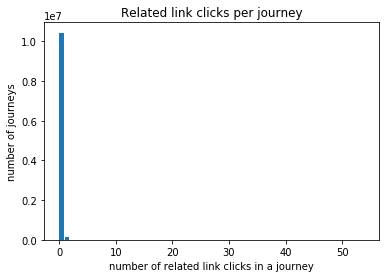

In [79]:
plt.bar(
    group_by_rl_clicks_df['Related Links Clicks per seq'],
    group_by_rl_clicks_df['Occurrences'],
    align='edge')
plt.title('Related link clicks per journey')
plt.ylabel('number of journeys')
plt.xlabel('number of related link clicks in a journey')

Text(0.5, 0, 'number of related link clicks in a journey')

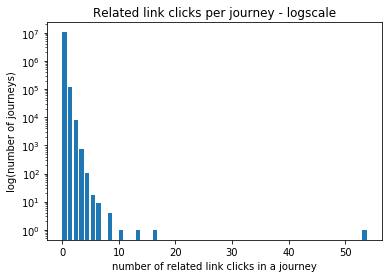

In [80]:
plt.bar(
    group_by_rl_clicks_df['Related Links Clicks per seq'],
    group_by_rl_clicks_df['Occurrences'],
    log=True
    ,align='edge'
)
plt.title('Related link clicks per journey - logscale')
plt.ylabel('log(number of journeys)')
plt.xlabel('number of related link clicks in a journey')

Text(0.5, 0, 'number of related link clicks in a journey')

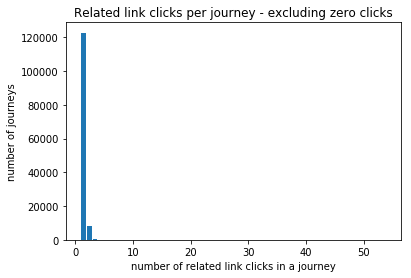

In [81]:
plt.bar(
    group_by_rl_clicks_df_bar_zero['Related Links Clicks per seq'],
    group_by_rl_clicks_df_bar_zero['Occurrences'],
    align='edge')
plt.title('Related link clicks per journey - excluding zero clicks')
plt.ylabel('number of journeys')
plt.xlabel('number of related link clicks in a journey')

Text(0.5, 0, 'number of related link clicks in a journey')

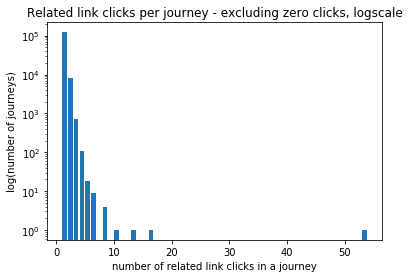

In [82]:
plt.bar(
    group_by_rl_clicks_df_bar_zero['Related Links Clicks per seq'],
    group_by_rl_clicks_df_bar_zero['Occurrences'],
    log=True
    ,align='edge'
)
plt.title('Related link clicks per journey - excluding zero clicks, logscale')
plt.ylabel('log(number of journeys)')
plt.xlabel('number of related link clicks in a journey')

## proportion of journeys with a page sequence including content and related links only

There is no statistically significant difference in the proportion of journeys with a page sequence including content and related links only (including loops) between page variant A and page variant B

\begin{equation*}
\frac{\text{total number of journeys that only contain content pages and related links (i.e. no nav pages)}}{\text{total number of journeys}}
\end{equation*}

### total number of journeys that only contain content pages and related links (i.e. no nav pages)
This will be easier to calculate as total number of journeys that do not contain clicks on navigation elements (home, breadcrumbs, search, explore this topic)

## Other stuff

### total number of pageviews
Not sure we're using this in our metrics

Should these only include ones that HAD related links on them??

If we had col PageSeq_Length we could use that instead

In [21]:
len(ast.literal_eval(df['Page_List'][2034757]))

4

In [22]:
def number_of_pageviews(page_list):
    return len(ast.literal_eval(page_list))

In [23]:
df['pageviews'] = df['Page_List'].map(number_of_pageviews)

In [24]:
df['absolute pageviews count'] = df['pageviews'] * df['Occurrences']

In [26]:
df.head(2)

,Sequence,PageSequence,Occurrences,Page_Seq_Occurrences,DeviceCategories,Dates,Page_Event_List,Page_List,PageSequence_internal,Event_List,num_event_cats,Event_cats_agg,Event_cat_act_agg,Page_List_NL,Page_Seq_NL,Occurrences_NL,pageviews,absolute pageviews count
0,/guidance/rates-and-thresholds-for-employers-2016-to-2017<<PAGE<:<NULL<:<NULL,/guidance/rates-and-thresholds-for-employers-2016-to-2017,87,306.0,"[('desktop', 64), ('mobile', 11), ('tablet', 12)]","[('20181031', 33), ('20181029', 27), ('20181102', 17), ('20181104', 10)]","[('/guidance/rates-and-thresholds-for-employers-2016-to-2017', 'PAGE<:<NULL<:<NULL')]",['/guidance/rates-and-thresholds-for-employers-2016-to-2017'],/guidance/rates-and-thresholds-for-employers-2016-to-2017,"[('PAGE_NULL', 'PAGE_NULL')]",1,"[('PAGE_NULL', 1)]","[(('PAGE_NULL', 'PAGE_NULL'), 1)]",['/guidance/rates-and-thresholds-for-employers-2016-to-2017'],/guidance/rates-and-thresholds-for-employers-2016-to-2017,6198.0,1,87
1,/sure-start-maternity-grant/how-to-claim<<PAGE<:<NULL<:<NULL>>/government/publications/sure-start-maternity-grant-claim-form<<PAGE<:<NULL<:<NULL>>/government/publications/sure-start-maternity-grant-claim-form<<EVENT<:<External Link Clicked<:<https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/749722/sure-start-maternity-grant-sf100.pdf>>/government/publications/sure-start-maternity-grant-claim-form<<EVENT<:<Download Link Clicked<:<https://assets.pu...,/sure-start-maternity-grant/how-to-claim>>/government/publications/sure-start-maternity-grant-claim-form,104,385.0,"[('mobile', 50), ('desktop', 50), ('tablet', 4)]","[('20181031', 34), ('20181029', 31), ('20181102', 24), ('20181104', 15)]","[('/sure-start-maternity-grant/how-to-claim', 'PAGE<:<NULL<:<NULL'), ('/government/publications/sure-start-maternity-grant-claim-form', 'PAGE<:<NULL<:<NULL'), ('/government/publications/sure-start-maternity-grant-claim-form', 'EVENT<:<External Link Clicked<:<https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/749722/sure-start-maternity-grant-sf100.pdf'), ('/government/publications/sure-start-maternity-grant-claim-form', 'EVENT<:<Download Link Clic...","['/sure-start-maternity-grant/how-to-claim', '/government/publications/sure-start-maternity-grant-claim-form']",/sure-start-maternity-grant/how-to-claim>>/government/publications/sure-start-maternity-grant-claim-form,"[('PAGE_NULL', 'PAGE_NULL'), ('PAGE_NULL', 'PAGE_NULL'), ('External Link Clicked', 'https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/749722/sure-start-maternity-grant-sf100.pdf'), ('Download Link Clicked', 'https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/749722/sure-start-maternity-grant-sf100.pdf')]",3,"[('PAGE_NULL', 2), ('External Link Clicked', 1), ('Download Link Clicked', 1)]","[(('PAGE_NULL', 'PAGE_NULL'), 2), (('External Link Clicked', 'https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/749722/sure-start-maternity-grant-sf100.pdf'), 1), (('Download Link Clicked', 'https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/749722/sure-start-maternity-grant-sf100.pdf'), 1)]","['/sure-start-maternity-grant/how-to-claim', '/government/publications/sure-start-maternity-grant-claim-form']",/sure-start-maternity-grant/how-to-claim>>/government/publications/sure-start-maternity-grant-claim-form,7010.0,2,208
